In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'Synthetic Multispectral Crops Data.xlsx'

try:
    df = pd.read_excel(file_path)
except Exception:
    df = pd.read_csv(file_path)

print(df.head())
print(df.info())
print(df.describe())

   ndvi_mean  ndvi_std  ndvi_min  ndvi_max     gndvi      savi       evi  \
0   0.462178  0.118574  0.345162  0.527650  0.434070  0.493184  0.426272   
1   0.865500  0.023196  0.814436  1.056953  0.855039  0.887622  0.807505   
2   0.712396  0.022876  0.539486  0.881657  0.628224  0.721757  0.708308   
3   0.619061  0.062069  0.515087  0.696248  0.578767  0.609120  0.640899   
4   0.309213  0.083524  0.178098  0.466014  0.357456  0.357234  0.434805   

   red_edge_1  red_edge_2  nir_reflectance  soil_brightness  canopy_density  \
0    0.538210    0.387860         0.715725         0.531091        0.586647   
1    0.200828    0.391693         0.350926         0.304631        0.418664   
2    0.139121    0.474993         0.479509         0.394532        0.829622   
3    0.494059    0.354945         0.555526         0.594686        0.882743   
4    0.517743    0.152411         0.767144         0.781283        0.916408   

   moisture_index  grid_x  grid_y crop_health_label  
0        0.679

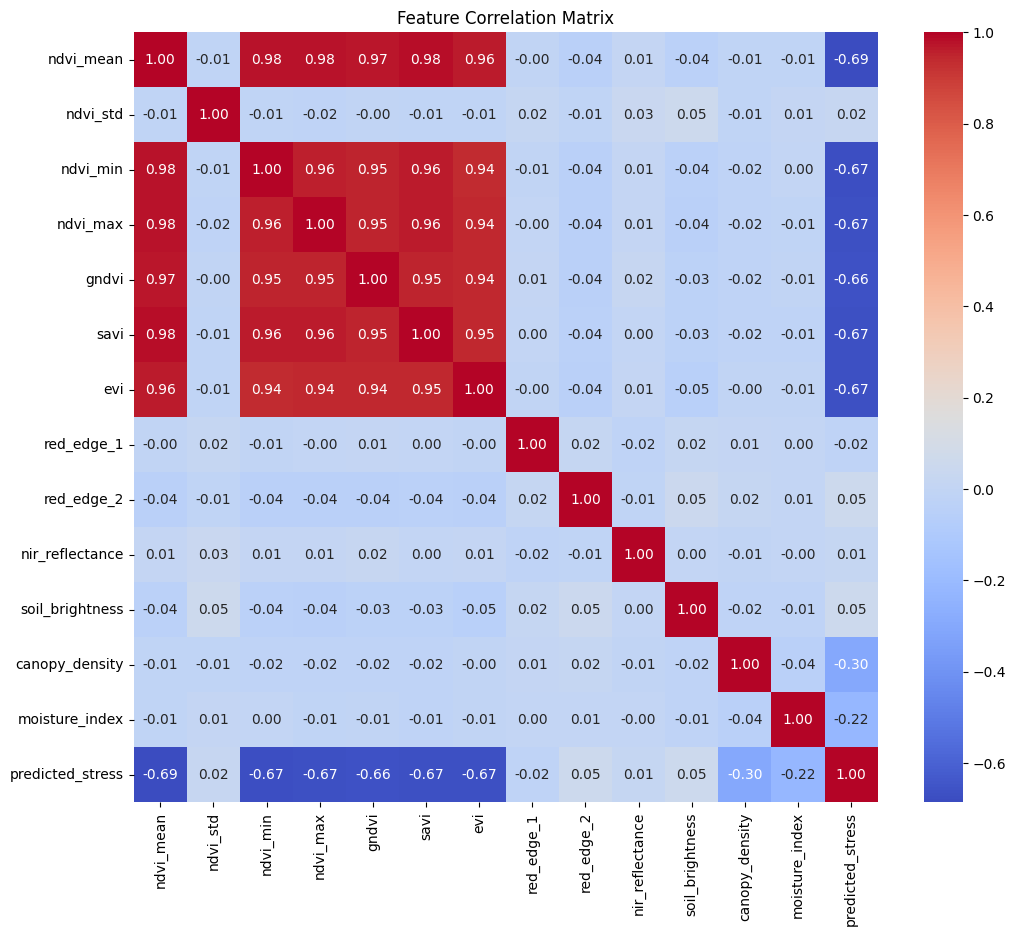

In [ ]:
numeric_df = df.drop(['crop_health_label', 'target', 'grid_x', 'grid_y', 'sector'], axis=1, errors='ignore')

plt.figure(figsize=(12, 10))
correlation_matrix = numeric_df.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

print(df['crop_health_label'].value_counts())

le = LabelEncoder()
df['target'] = le.fit_transform(df['crop_health_label'])

X = df.drop(['crop_health_label', 'target', 'grid_x', 'grid_y'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

if len(le.classes_) == 2:
    y_prob = model.predict_proba(X_test)[:, 1]
    roc_score = roc_auc_score(y_test, y_prob)
    print(f'ROC-AUC Score: {roc_score}')
else:
    y_prob = model.predict_proba(X_test)
    roc_score = roc_auc_score(y_test, y_prob, multi_class='ovr')
    print(f'ROC-AUC Score (One-vs-Rest): {roc_score}')

print(classification_report(y_test, y_pred, target_names=le.classes_))

crop_health_label
Healthy     780
Stressed    420
Name: count, dtype: int64
ROC-AUC Score: 0.9821428571428572
              precision    recall  f1-score   support

     Healthy       0.95      0.96      0.95       156
    Stressed       0.92      0.90      0.91        84

    accuracy                           0.94       240
   macro avg       0.93      0.93      0.93       240
weighted avg       0.94      0.94      0.94       240



In [ ]:
from sklearn.model_selection import cross_val_score

train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:     {test_acc:.4f}")

cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Average CV Accuracy:     {cv_scores.mean():.4f}")

if train_acc - test_acc > 0.10:
    print("\nPotential Overfitting")
else:
    print("\nModel is generalizing")

Training Accuracy: 1.0000
Test Accuracy:     0.9375

Cross-Validation Scores: [0.925      0.93333333 0.89583333 0.9125     0.94583333]
Average CV Accuracy:     0.9225

Model is generalizing


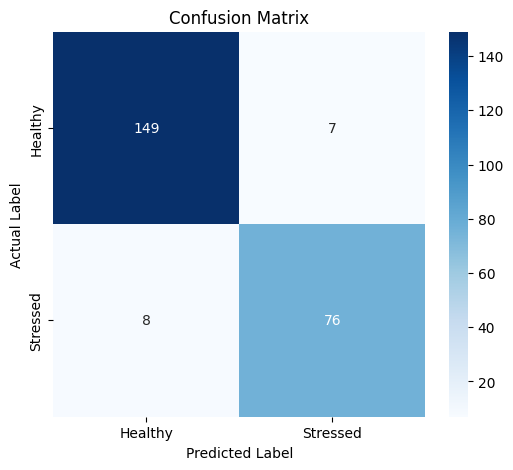

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

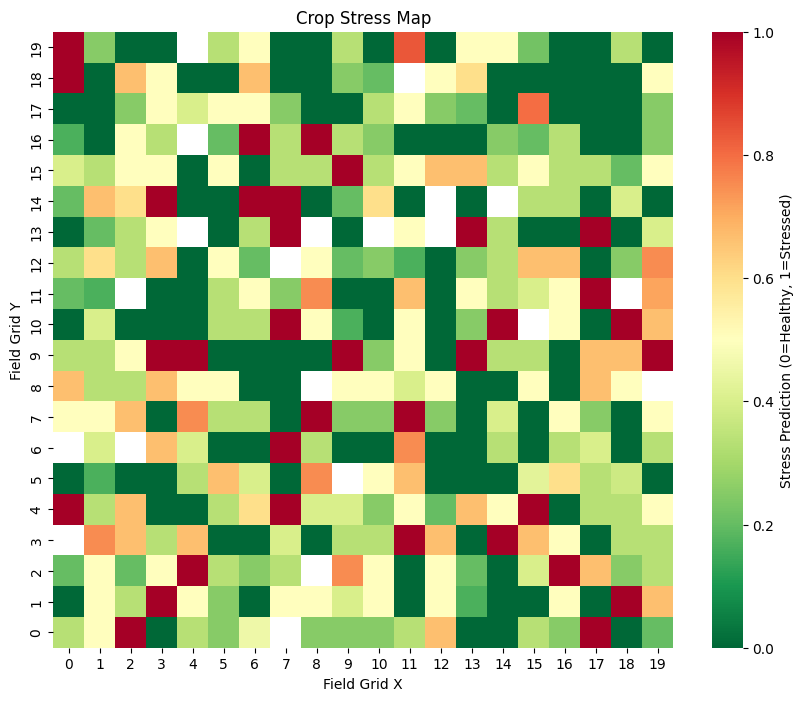

In [ ]:
df['predicted_stress'] = model.predict(X)

heatmap_data = df.pivot_table(index='grid_y', columns='grid_x', values='predicted_stress')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='RdYlGn_r', annot=False, cbar_kws={'label': 'Stress Prediction (0=Healthy, 1=Stressed)'})

plt.title('Crop Stress Map')
plt.xlabel('Field Grid X')
plt.ylabel('Field Grid Y')

plt.gca().invert_yaxis()
plt.show()

/tmp/ipython-input-4171988222.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')


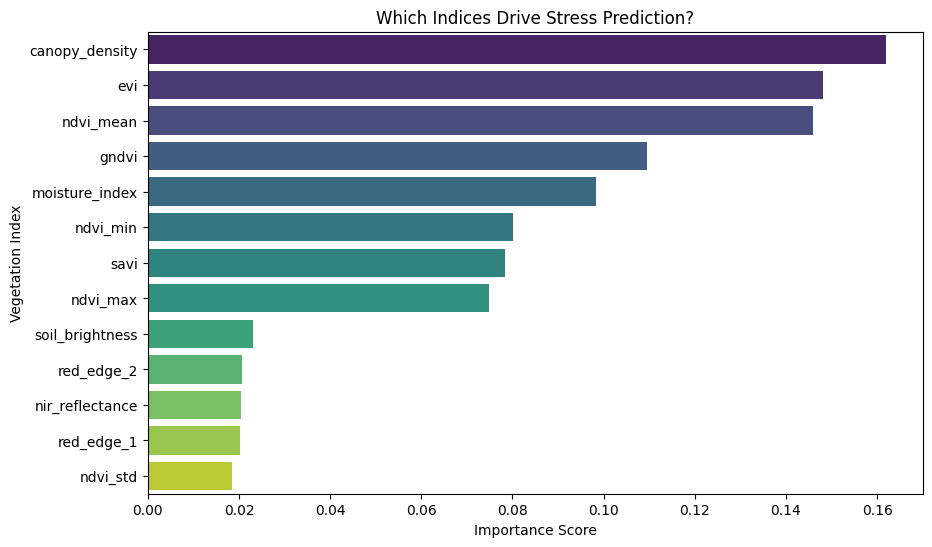

Top 3 Predictive Features:
           Feature  Importance
11  canopy_density    0.161920
6              evi    0.148099
0        ndvi_mean    0.145940


In [ ]:
importances = model.feature_importances_
feature_names = X.columns

feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Which Indices Drive Stress Prediction?')
plt.xlabel('Importance Score')
plt.ylabel('Vegetation Index')
plt.show()

print("Top 3 Predictive Features:")
print(feature_imp_df.head(3))

In [ ]:
def generate_drone_strategy(df):
    conditions = [
        (df['grid_x'] < 10) & (df['grid_y'] >= 10),
        (df['grid_x'] >= 10) & (df['grid_y'] >= 10),
        (df['grid_x'] < 10) & (df['grid_y'] < 10),
        (df['grid_x'] >= 10) & (df['grid_y'] < 10)
    ]

    quadrants = ['Zone A (Top-Left)', 'Zone B (Top-Right)', 'Zone C (Bottom-Left)', 'Zone D (Bottom-Right)']
    df['sector'] = np.select(conditions, quadrants, default='Unknown')

    report = df.groupby('sector')['predicted_stress'].mean().reset_index()
    report.columns = ['Sector', 'Stress_Percentage']

    print("DRONE INSPECTION STRATEGY REPORT:")
    for index, row in report.iterrows():
        stress_pct = row['Stress_Percentage'] * 100
        print(f"\n{row['Sector']}: {stress_pct:.1f}% Stress Detected")

        if stress_pct > 20:
            print("-ACTION: Deploy low-altitude drone for thermal/RGB inspection.")
        elif stress_pct > 5:
            print("-ACTION: Schedule secondary flyover in 48 hours.")
        else:
            print("-ACTION: Maintain standard weekly monitoring.")

generate_drone_strategy(df)

DRONE INSPECTION STRATEGY REPORT:

Zone A (Top-Left): 31.4% Stress Detected
-ACTION: Deploy low-altitude drone for thermal/RGB inspection.

Zone B (Top-Right): 32.2% Stress Detected
-ACTION: Deploy low-altitude drone for thermal/RGB inspection.

Zone C (Bottom-Left): 39.1% Stress Detected
-ACTION: Deploy low-altitude drone for thermal/RGB inspection.

Zone D (Bottom-Right): 37.0% Stress Detected
-ACTION: Deploy low-altitude drone for thermal/RGB inspection.


#Downloading model

In [13]:
import joblib
from google.colab import files

filename = 'crop_health_rf_model.pkl'
joblib.dump(model, filename)
print(f"Model saved as {filename}")

files.download(filename)

Model saved as crop_health_rf_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>